## Understand Data

### Download Data

In [101]:
import torch
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt

RANDOM_SEED=42

In [102]:
train_data = datasets.FashionMNIST(
    root='../data',
    train=True,
    download=True,
    target_transform=None,
    transform=torchvision.transforms.ToTensor()
)

In [103]:
test_data = datasets.FashionMNIST(
    root='../data',
    train=False,
    download=True,
    target_transform=None,
    transform=torchvision.transforms.ToTensor()
)

### Understanding data

In [104]:
len(train_data), len(test_data), type(train_data)

(60000, 10000, torchvision.datasets.mnist.FashionMNIST)

In [105]:
image, label = train_data[0]
label, image

(9,
 tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.00

In [106]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [107]:
image.shape, type(image), label, type(label)

(torch.Size([1, 28, 28]), torch.Tensor, 9, int)

### Visualize data

Text(0.5, 1.0, 'Ankle boot')

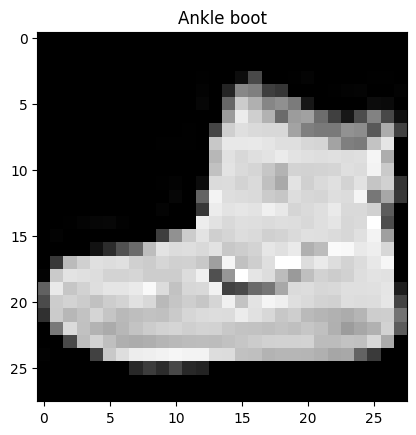

In [108]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(train_data.classes[label])

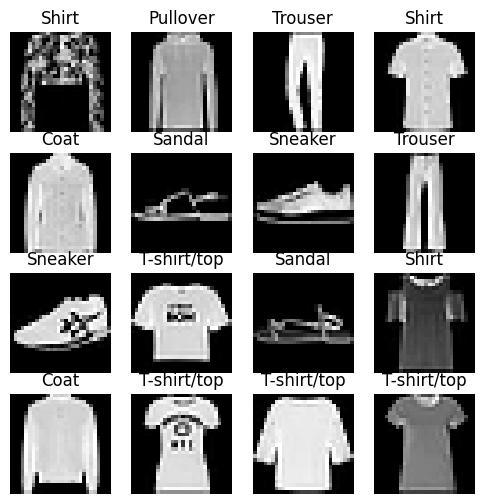

In [109]:
torch.manual_seed(RANDOM_SEED)
fig = plt.figure(figsize=(6,6))
rows, cols = 4 , 4
for i in range (rows * cols):
    idx = torch.randint(low=0, high=len(train_data)-1, size=(1,)).item()
    image, label = train_data[idx]
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(train_data.classes[label])
    plt.axis(False)

## Prepare DataLoader

In [110]:
from torch.utils.data import DataLoader

In [111]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=False
)

In [112]:
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"len of test and train data loader: {len(train_dataloader), len(test_dataloader)}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000016531A0C830>, <torch.utils.data.dataloader.DataLoader object at 0x0000016531A0DEE0>)
len of test and train data loader: (1875, 313)


In [113]:
sample_train_batch, sample_train_label_batch = next(iter(train_dataloader))
sample_train_batch.shape, sample_train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Create a baseline model

In [114]:
from torch import nn
from helper_functions import accuracy_fn, plot_loss_curves
import timer
from tqdm.auto import tqdm
NUM_CLASSES = len(train_data.classes)
HIDDEN_UNITS = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [115]:
model_0 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=HIDDEN_UNITS),
    nn.Linear(in_features=HIDDEN_UNITS, out_features=NUM_CLASSES)
).to(device)

In [116]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1,
)


In [117]:
epochs = 3
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(epochs)):
    model_0.train()
    train_loss, train_acc = 0, 0

    for X_train, y_train in train_dataloader:
        X_train, y_train = X_train.to(device), y_train.to(device)

        # Forward
        y_logits = model_0(X_train)
        loss = loss_fn(y_logits, y_train)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        train_loss += loss.item()
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        train_acc += accuracy_fn(y_train, y_pred)

    # Average for epoch
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluation loop (optional but recommended)
    model_0.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_logits = model_0(X_test)
            loss = loss_fn(test_logits, y_test)
            test_loss += loss.item()
            y_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_acc += accuracy_fn(y_test, y_pred)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
            f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


 33%|███▎      | 1/3 [00:09<00:18,  9.36s/it]

Epoch 1/3 Train Loss: 0.5890 | Train Acc: 79.11% Test Loss: 0.5088 | Test Acc: 82.13%


100%|██████████| 3/3 [00:27<00:00,  9.07s/it]


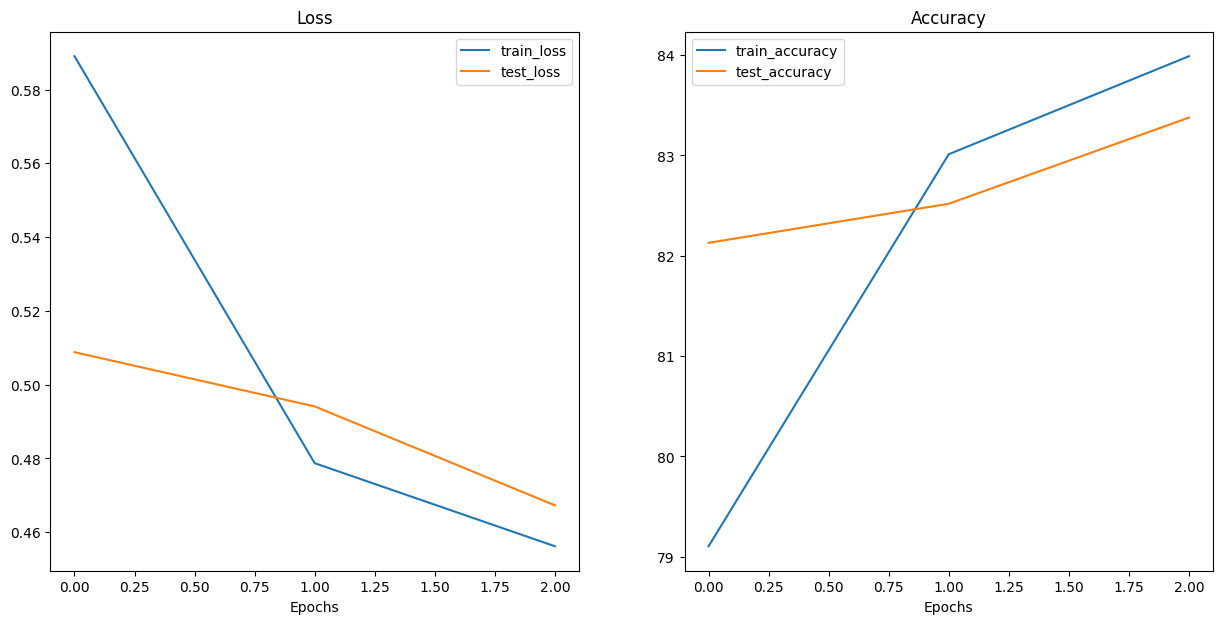

In [118]:
plot_loss_curves({
    "train_loss": train_losses,
    "train_acc": train_accuracies,
    "test_loss": test_losses,
    "test_acc": test_accuracies,
})